In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, medfilt
from scipy.ndimage import uniform_filter1d
from scipy.fft import fft, fftfreq, ifft

# ===============================
# 1. LOAD DATA
# ===============================

csv_path = "imu_data_02.csv"
df = pd.read_csv(csv_path, sep=';', decimal=',')

# Convertir todas las columnas a numérico
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

fs = 100  # Hz

ignore_time = 5  # segundos a ignorar
ignore_samples = ignore_time * fs

# Recortar los primeros 5 segundos
df = df.iloc[ignore_samples:].reset_index(drop=True)


df

,UncompMagX,UncompMagY,UncompMagZ,UncompAccX,UncompAccY,UncompAccZ,UncompGyroX,UncompGyroY,UncompGyroZ,Temperature,Pressure
0,-0.177,0.137,-0.103,-4.607,0.021,-8.942,-0.181550,-1.220951,-0.084487,31.9,101.18
1,-0.177,0.134,-0.099,-4.304,-0.041,-8.797,-0.162838,-1.302550,-0.037182,31.9,101.19
2,-0.178,0.136,-0.097,-4.199,-0.268,-8.787,-0.270237,-1.596842,0.017087,31.9,101.17
3,-0.177,0.136,-0.090,-4.056,-0.164,-8.847,-0.222565,-1.957586,0.033017,31.9,101.17
4,-0.178,0.136,-0.088,-3.193,-0.766,-8.959,-0.532106,-2.429014,0.106467,31.9,101.17
...,...,...,...,...,...,...,...,...,...,...,...
1551,0.146,-0.147,-0.246,-3.606,0.198,-9.073,0.030771,-0.097926,-0.012256,31.9,101.18
1552,0.146,-0.145,-0.247,-3.553,0.191,-9.017,0.031749,-0.073756,-0.008343,31.9,101.17
1553,0.147,-0.148,-0.247,-3.549,0.249,-9.080,0.033701,-0.057866,-0.006572,31.9,101.18
1554,0.146,-0.146,-0.247,-3.651,0.355,-9.072,0.025097,-0.033111,-0.008805,31.9,101.17


In [2]:
# ===============================
# 2. DOMINANT FREQUENCY ESTIMATION
# ===============================

ignore_time = 0
ignore_samples = ignore_time * fs

acc_mag_raw = np.sqrt(df['UncompAccX']**2 +
                      df['UncompAccY']**2 +
                      df['UncompAccZ']**2)

acc_mag_trim = acc_mag_raw.iloc[ignore_samples:]

N = len(acc_mag_trim)
fft_mag = np.abs(np.fft.rfft(acc_mag_trim - np.mean(acc_mag_trim)))
freq = np.fft.rfftfreq(N, 1/fs)

dominant = freq[np.argmax(fft_mag)]

# Band-pass adaptado
if dominant < 0.3:
    lowcut = 0.3
    highcut = 20
else:
    lowcut  = max(0.2, dominant * 0.2)
    highcut = min(20,  dominant * 10)

print("Dominant freq:", dominant)
print("lowcut:", lowcut, "highcut:", highcut)



Dominant freq: 1.4138817480719794
lowcut: 0.2827763496143959 highcut: 14.138817480719794


In [3]:
# ===============================
# 3. BAND-PASS FILTERING
# ===============================

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, data)

df['AccX_filt'] = bandpass_filter(df['UncompAccX'], lowcut, highcut, fs)
df['AccY_filt'] = bandpass_filter(df['UncompAccY'], lowcut, highcut, fs)
df['AccZ_filt'] = bandpass_filter(df['UncompAccZ'], lowcut, highcut, fs)


In [4]:
# ===============================
# 4. FEATURE EXTRACTION
# ===============================

acc_mag = np.sqrt(df['AccX_filt']**2 +
                  df['AccY_filt']**2 +
                  df['AccZ_filt']**2)

gyro_mag = np.sqrt(df['UncompGyroX']**2 +
                   df['UncompGyroY']**2 +
                   df['UncompGyroZ']**2)

window_ms = 100
window_samples = int(window_ms / 1000 * fs)

def sliding_variance(signal, window_size):
    mean_sq = uniform_filter1d(signal**2, size=window_size)
    sq_mean = uniform_filter1d(signal, size=window_size)**2
    return np.maximum(mean_sq - sq_mean, 0)

acc_var = sliding_variance(acc_mag, window_samples)
gyro_var = sliding_variance(gyro_mag, window_samples)



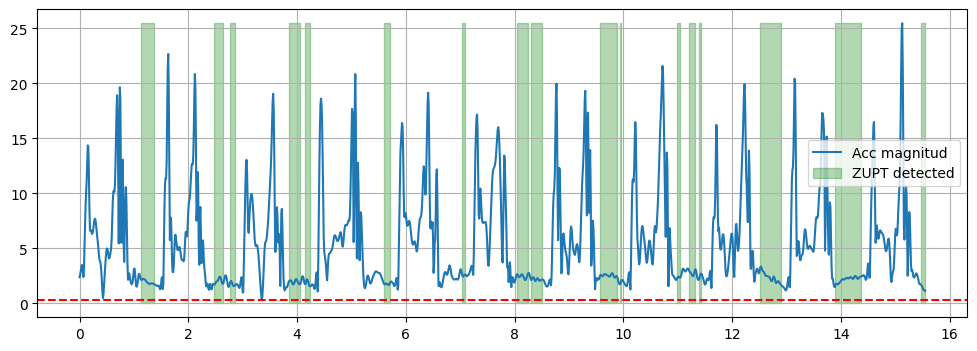

In [5]:
# ===============================
# 5. ZUPT DETECTION
# ===============================

acc_var_thresh = np.percentile(acc_var, 30)
gyro_var_thresh = np.percentile(gyro_var, 25)

zupt_mask = (acc_var < acc_var_thresh) & (gyro_var < gyro_var_thresh)

zupt_mask = medfilt(zupt_mask.astype(float), kernel_size=7) > 0.5
zupt_final = zupt_mask

# Plot
t = np.arange(len(df)) / fs

plt.figure(figsize=(12,4))
plt.plot(t, acc_mag, label='Acc magnitud')
plt.fill_between(t, 0, np.max(acc_mag),
                 where=zupt_final, color='green', alpha=0.3,
                 label='ZUPT detected')
plt.axhline(np.sqrt(acc_var_thresh), color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# ===============================
# 6. VELOCITY AND POSITION ESTIMATION
# ===============================

vel = np.zeros((len(df), 3))

for i in range(1, len(df)):
    dt = 1/fs
    vel[i, 0] = vel[i-1, 0] + df['AccX_filt'][i] * dt
    vel[i, 1] = vel[i-1, 1] + df['AccY_filt'][i] * dt
    vel[i, 2] = vel[i-1, 2] + (df['AccZ_filt'][i] - 1) * dt  # restar gravedad

    if zupt_final[i]:
        vel[i, :] = 0

pos = np.zeros((len(df), 3))
for i in range(1, len(df)):
    dt = 1/fs
    pos[i] = pos[i-1] + vel[i] * dt


In [10]:
# ===============================
# 7. PERIODIC RECONSTRUCTION + FUSION
# ===============================

n_harmonics = 5
N_ref = int(2 * fs)

def periodic_reconstruction(signal):
    ref = signal[:N_ref]
    X = fft(ref)
    Xf = np.zeros_like(X)
    Xf[:n_harmonics+1] = X[:n_harmonics+1]
    Xf[-n_harmonics:] = X[-n_harmonics:]
    periodic = np.real(ifft(Xf))
    n_repeat = int(np.ceil((len(signal) - N_ref) / N_ref))
    return np.tile(periodic, n_repeat)[:len(signal)-N_ref]

alpha = 0.8

# X
x_period = periodic_reconstruction(pos[:,0])
pos_final_x = pos[:,0].copy()
pos_final_x[N_ref:] = alpha*pos[N_ref:,0] + (1-alpha)*x_period

# Y
y_period = periodic_reconstruction(pos[:,1])
pos_final_y = pos[:,1].copy()
pos_final_y[N_ref:] = alpha*pos[N_ref:,1] + (1-alpha)*y_period

# Z
z_period = periodic_reconstruction(pos[:,2])
pos_final_z = pos[:,2].copy()
pos_final_z[N_ref:] = alpha*pos[N_ref:,2] + (1-alpha)*z_period


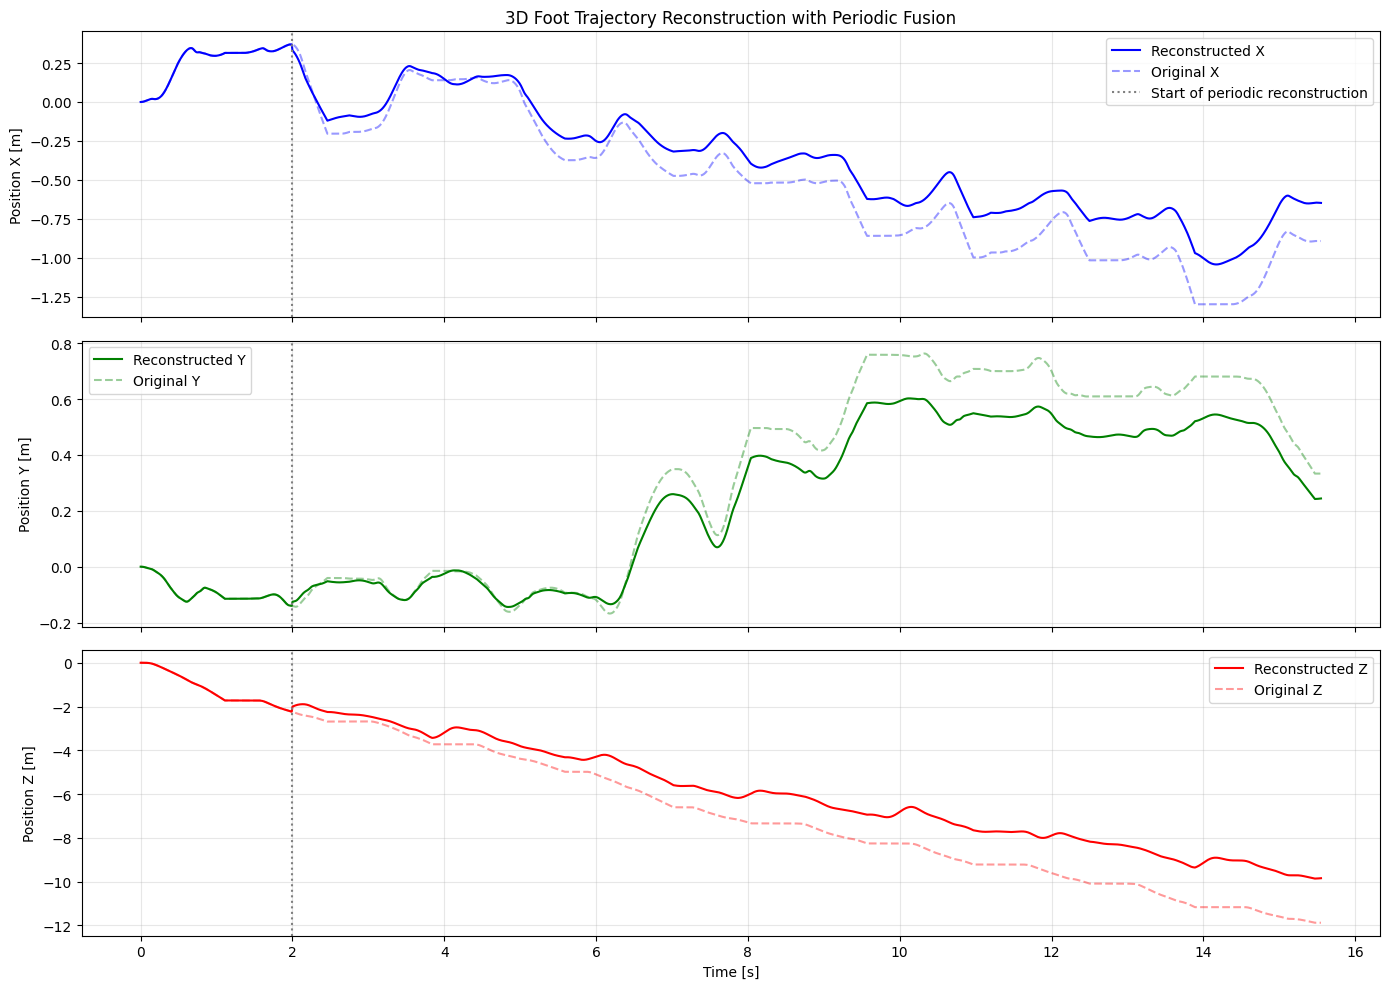

In [11]:
t = np.arange(len(pos)) / fs  # time vector

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# X-axis
axes[0].plot(t, pos_final_x, label='Reconstructed X', color='blue')
axes[0].plot(t, pos[:,0], label='Original X', color='blue', alpha=0.4, linestyle='--')
axes[0].axvline(x=N_ref/fs, color='gray', linestyle=':', label='Start of periodic reconstruction')
axes[0].set_ylabel('Position X [m]')
axes[0].set_title('3D Foot Trajectory Reconstruction with Periodic Fusion')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Y-axis
axes[1].plot(t, pos_final_y, label='Reconstructed Y', color='green')
axes[1].plot(t, pos[:,1], label='Original Y', color='green', alpha=0.4, linestyle='--')
axes[1].axvline(x=N_ref/fs, color='gray', linestyle=':')
axes[1].set_ylabel('Position Y [m]')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Z-axis
axes[2].plot(t, pos_final_z, label='Reconstructed Z', color='red')
axes[2].plot(t, pos[:,2], label='Original Z', color='red', alpha=0.4, linestyle='--')
axes[2].axvline(x=N_ref/fs, color='gray', linestyle=':')
axes[2].set_ylabel('Position Z [m]')
axes[2].set_xlabel('Time [s]')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
rms_x = np.sqrt(np.mean((pos_final_x[:N_ref] - pos[:N_ref,0])**2))
rms_y = np.sqrt(np.mean((pos_final_y[:N_ref] - pos[:N_ref,1])**2))
rms_z = np.sqrt(np.mean((pos_final_z[:N_ref] - pos[:N_ref,2])**2))
cycle_len = N_ref
n_cycles = int(len(pos_final_x)/cycle_len)

rms_cycles_x = []
rms_cycles_y = []
rms_cycles_z = []

for c in range(n_cycles):
    start = c*cycle_len
    end   = (c+1)*cycle_len
    rms_x = np.sqrt(np.mean((pos_final_x[start:end] - pos[start:end,0])**2))
    rms_y = np.sqrt(np.mean((pos_final_y[start:end] - pos[start:end,1])**2))
    rms_z = np.sqrt(np.mean((pos_final_z[start:end] - pos[start:end,2])**2))
    rms_cycles_x.append(rms_x)
    rms_cycles_y.append(rms_y)
    rms_cycles_z.append(rms_z)
    print(f"Ciclo {c+1} RMS -> X:{rms_x:.4f}, Y:{rms_y:.4f}, Z:{rms_z:.4f}")


Ciclo 1 RMS -> X:0.0000, Y:0.0000, Z:0.0000
Ciclo 2 RMS -> X:0.0699, Y:0.0129, Z:0.3488
Ciclo 3 RMS -> X:0.0880, Y:0.0077, Z:0.6318
Ciclo 4 RMS -> X:0.1303, Y:0.0660, Z:1.0248
Ciclo 5 RMS -> X:0.1802, Y:0.1334, Z:1.3081
Ciclo 6 RMS -> X:0.2260, Y:0.1612, Z:1.5554
Ciclo 7 RMS -> X:0.2522, Y:0.1439, Z:1.8202
